In [27]:
import re
from collections import Counter
import time

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
from sklearn import feature_extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from transformers import TFTrainer, TFTrainingArguments
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from xgboost import XGBClassifier

In [30]:
import nltk
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

## Data Analysis

In [31]:
TRAIN_PATH = 'SMSSpamCollection'

df = pd.read_csv(TRAIN_PATH,names = ['class','text'], delimiter = '\t')

df

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


/tmp/ipykernel_351201/874488902.py:45: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
/tmp/ipykernel_351201/874488902.py:51: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[df['class'] == "spam", "message_len"], shade=True, label="Spam",ax = axs[1,0])
/tmp/ipykernel_351201/874488902.py:63: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
/tmp/ipykernel_351201/874488902.py:69: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[df['class'] == "spam", "nwords"], shade=True, label="Spam", ax = axs[

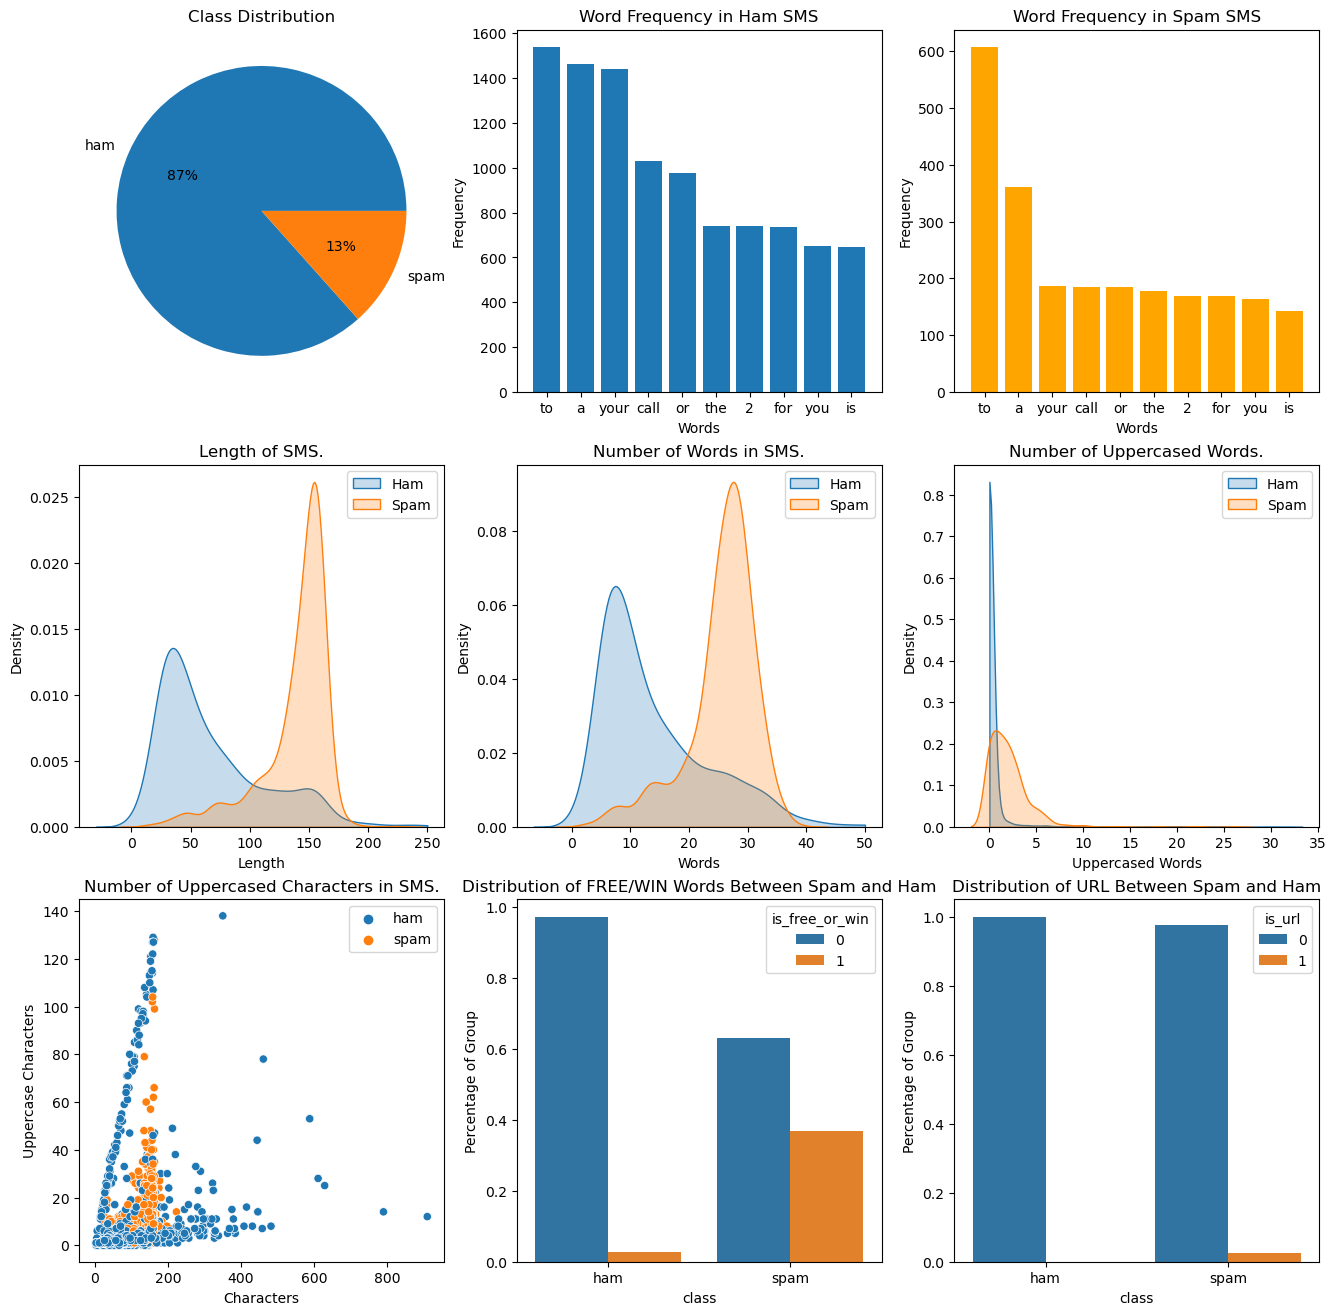

In [32]:
fig, axs = plt.subplots(3, 3, figsize =  (16,16))

# Class Distribution
class_value_counts = df['class'].value_counts(sort = True)

# Plot
axs[0,0].set_title("Class Distribution")
axs[0,0].pie(class_value_counts, labels = class_value_counts.index, autopct = "%1.0f%%")
axs[0,0].axis('off')


# Word Frequency
most_common_ham = pd.DataFrame.from_dict(
    
    Counter(" ".join(df.loc[df["class"]== "ham"]["text"]).split()).most_common(10)
)

most_common_ham = most_common_ham.rename(columns={0: "word_in_ham", 1 : "frequency"})


most_common_spam = pd.DataFrame.from_dict(
    
    Counter(" ".join(df.loc[df["class"]== "spam"]["text"]).split()).most_common(10)
)

most_common_spam = most_common_spam.rename(columns={0: "word_in_spam", 1 : "frequency"})

axs[0,1].set_title("Word Frequency in Ham SMS")
axs[0,1].bar(most_common_ham["word_in_ham"], most_common_ham["frequency"])
axs[0,1].set_xticks(np.arange(len(most_common_ham["word_in_ham"])))
axs[0,1].set_xticklabels(most_common_ham["word_in_ham"])
axs[0,1].set_xlabel("Words")
axs[0,1].set_ylabel("Frequency")

axs[0,2].set_title("Word Frequency in Spam SMS")
axs[0,2].bar(most_common_spam["word_in_spam"], most_common_spam["frequency"], color = 'orange')
axs[0,2].set_xticks(np.arange(len(most_common_spam["word_in_spam"])))
axs[0,1].set_xticklabels(most_common_spam["word_in_spam"])
axs[0,2].set_xlabel("Words")
axs[0,2].set_ylabel("Frequency")

# Length
df["message_len"] = df["text"].apply(len)

sns.kdeplot(
    df.loc[df['class'] == "ham", "message_len"],
    shade=True,
    label="Ham",
    clip=(-50, 250), ax = axs[1,0]
)
sns.kdeplot(df.loc[df['class'] == "spam", "message_len"], shade=True, label="Spam",ax = axs[1,0])
axs[1,0].set(
    xlabel="Length",
    ylabel="Density",
    title="Length of SMS.",
)
axs[1,0].legend(loc="upper right")


# Number of Words
df["nwords"] = df["text"].apply(lambda s: len(re.findall(r"\w+", s)))

sns.kdeplot(
    df.loc[df['class'] == "ham", "nwords"],
    shade=True,
    label="Ham",
    clip=(-10, 50), ax = axs[1,1]
)
sns.kdeplot(df.loc[df['class'] == "spam", "nwords"], shade=True, label="Spam", ax = axs[1,1])

axs[1,1].set(
    xlabel="Words",
    ylabel="Density",
    title="Number of Words in SMS.",
)
axs[1,1].legend(loc="upper right")


# Number of Uppercased Words
df["nupperwords"] = df["text"].apply(
    lambda s: len(re.findall(r"\b[A-Z][A-Z]+\b", s))
)
sns.kdeplot(
    df.loc[df['class'] == "ham", "nupperwords"],
    shade=True,
    label="Ham",
    clip=(0, 35), ax = axs[1,2]
)
sns.kdeplot(df.loc[df['class'] == "spam", "nupperwords"], shade=True, label="Spam", ax = axs[1,2])
axs[1,2].set(
    xlabel="Uppercased Words",
    ylabel="Density",
    title="Number of Uppercased Words.",
)
axs[1,2].legend(loc="upper right")

# Number of Uppercased Characters
df["nupperchars"] = df["text"].apply(
    lambda s: sum(1 for c in s if c.isupper())
)

sns.scatterplot(x="message_len", y="nupperchars", hue="class", data=df, ax = axs[2,0])
axs[2,0].set(
    xlabel="Characters",
    ylabel="Uppercase Characters",
    title="Number of Uppercased Characters in SMS.",
)
axs[2,0].legend(loc="upper right")


# Contains free or win
df["is_free_or_win"] = df["text"].apply(
    lambda s: int("free" in s.lower() or "win" in s.lower())
)


grouped_data = (
    df.groupby("class")["is_free_or_win"]
    .value_counts(normalize=True)
    .rename("Percentage of Group")
    .reset_index()
)

axs[2,1].set_title("Distribution of FREE/WIN Words Between Spam and Ham")

sns.barplot(
    x="class",
    y="Percentage of Group",
    hue="is_free_or_win",
    data=grouped_data, ax = axs[2,1]
)


# Contains url
df["is_url"] = df["text"].apply(
    lambda s: 1
    if re.search(
        r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+",
        s,
    )
    else 0
)


grouped_data = (
    df.groupby("class")["is_url"]
    .value_counts(normalize=True)
    .rename("Percentage of Group")
    .reset_index()
)

axs[2,2].set_title("Distribution of URL Between Spam and Ham")

sns.barplot(
    x="class",
    y="Percentage of Group",
    hue="is_url",
    data=grouped_data, ax = axs[2,2]
)

plt.savefig('assets/data_analysis.jpg')
plt.show()
